In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [50]:
import os
import glob

from pandas.api.types import CategoricalDtype

HOME = "/home/kwatchar3/spauq-home/spauq/expt/degradation/timit/results-2s/noisepan"

results = glob.glob(os.path.join(HOME, "*.csv"))

dfs = []

for r in results:
    df = pd.read_csv(r).rename(columns={'Unnamed: 0': 'filename', 'Unnamed: 1': 'snr', 'Unnamed: 2': 'est_pan'})
    dfs.append(df)
    
df = pd.concat(dfs).reset_index()

# df['ref_pan'] = df['ref_pan'].apply(lambda x: np.round(x*10)/10)
df['est_pan'] = df['est_pan'].apply(lambda x: np.round(x*10)/10)
# df['pan_err'] = df['est_pan'] - df['ref_pan']

df0 = df.copy()

/tmp/ipykernel_1034149/1708285594.py:27: RuntimeWarning: divide by zero encountered in log2
  return np.where(snr != 0, 0.15 * np.sign(snr) * (np.log2(np.abs(snr)/3)+1)/10, 0)
/tmp/ipykernel_1034149/1708285594.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(snr != 0, 0.15 * np.sign(snr) * (np.log2(np.abs(snr)/3)+1)/10, 0)


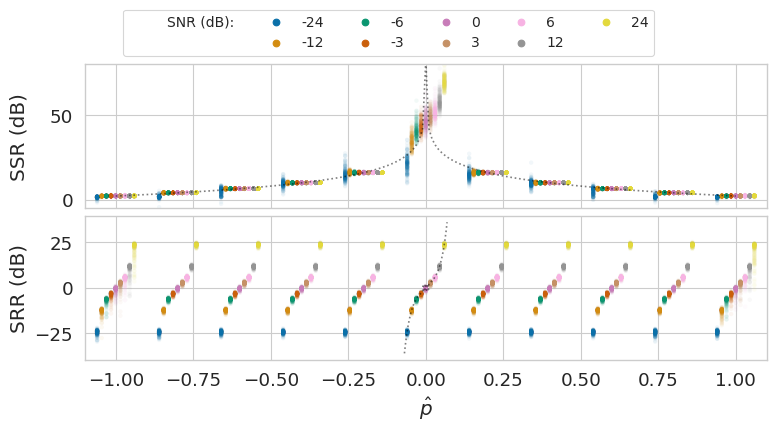

In [53]:
df = df0.copy()

p = np.concatenate([np.linspace(-1, 1, 100)])

def theoretical_ssr(p, upper, p0=0):
    if upper:
        t = np.sin(0.25 * np.pi * (p+1)) * np.sin(0.25 * np.pi * (p0+1)) * (1 - -1)
    else:
        t = np.sin(0.25 * np.pi * (p+1)) * np.sin(0.25 * np.pi * (p0+1)) * 0
    ssr = -10*np.log10(2 - 2 * np.cos(0.25 * np.pi * (p-p0)) + t)
    
    return ssr


sns.set("paper", "whitegrid", "colorblind", font_scale=1.5)
f, axs = plt.subplots(2, 1, figsize=(8,4))


ax = axs[0]
palette = sns.color_palette("colorblind", n_colors=len(df.snr.unique()), desat=0.9)

dmax = 32

dfm = df.groupby(['snr', 'est_pan']).median(numeric_only=True).reset_index()

def snr_map(snr):
    return np.where(snr != 0, 0.15 * np.sign(snr) * (np.log2(np.abs(snr)/3)+1)/10, 0)


df['est_pan'] = df[['snr', 'est_pan']].apply(lambda r: r.est_pan + snr_map(r.snr), axis=1)
sns.scatterplot(df, y='SSR', x='est_pan', hue='snr', palette=palette, ax=ax, edgecolor="none", alpha=0.05, s=10)
h, l = ax.get_legend_handles_labels()


p = np.concatenate([np.linspace(-1, -1e-4, 100),np.linspace(1e-4, 1, 100)])
ssr0 = theoretical_ssr(p, 0)
sns.lineplot(x=p, y=ssr0, ls=":", ax=ax, color="black", zorder=1, alpha=0.5)
xlim = [-1.1, 1.1]
ax.set(ylim=[-5, 80], ylabel='SSR (dB)', xlim=xlim, xticklabels=[], xlabel=None)

ax.legend().remove()
h = [plt.plot([], marker="", ls="")[0], plt.plot([], marker="", ls="")[0]] + h
l = ['SNR (dB):', ""] + l
f.legend(h, l, loc='upper center', fontsize=10, ncols=6, bbox_to_anchor=(0.5, 1.1))

ax = axs[1]
sns.scatterplot(df, y='SRR', x='est_pan', hue='snr', palette=palette, ax=ax, edgecolor="none", alpha=0.05, s=10, legend=False)
ax.set(ylabel='SRR (dB)', xlabel='$\hat{p}$', xlim=xlim)

snr = np.concatenate([np.linspace(-36, -1, 100), np.linspace(1, 36, 100)])
sns.lineplot(x=snr_map(snr), y=snr, ls=":", ax=ax, color="black", zorder=1, alpha=0.5)

plt.tight_layout()
f.align_ylabels(axs)
f.subplots_adjust(wspace=0, hspace=0.05)

plt.savefig("figs/snrpan.pdf", bbox_inches='tight')

plt.show()

In [52]:
import json
df = df0.copy()
df['scalex'] = df.apply(lambda r: str(
    np.round(
        np.sqrt(np.sum(np.square(json.loads(r.scale)), axis=1)) - ideal_gain(r.est_pan), 
        3)),
                        axis=1
                       )

NameError: name 'ideal_gain' is not defined

In [ ]:
def ideal_gain(p):
    return np.array([np.cos(0.25*np.pi*(p+1)), np.sin(0.25*np.pi*(p+1))])

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df.groupby(['snr', 'est_pan']).value_counts(['scalex']))

In [ ]:
sns.scatterplot(df, x='snr', y='r2rshift', ax=ax, alpha=0.01)